In [ ]:
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install seaborn
!pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Carico i dati e ricostruisco per comodità una tabella unica, etichettando le righe che saranno di train e quelle che saranno di test

In [17]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

train_set["test"] = 0
test_set["test"] = 1

all_data = pd.concat([train_set, test_set])

Stampo alcune prime informazioni sulla natura dei dati

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 0 to 1690
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             5634 non-null   object 
 1   customerID        5634 non-null   object 
 2   gender            5634 non-null   object 
 3   SeniorCitizen     5634 non-null   int64  
 4   Partner           5634 non-null   object 
 5   Dependents        5634 non-null   object 
 6   tenure            5634 non-null   int64  
 7   PhoneService      5634 non-null   object 
 8   MultipleLines     5634 non-null   object 
 9   InternetService   5634 non-null   object 
 10  OnlineSecurity    5634 non-null   object 
 11  OnlineBackup      5634 non-null   object 
 12  DeviceProtection  5634 non-null   object 
 13  TechSupport       5634 non-null   object 
 14  StreamingTV       5634 non-null   object 
 15  StreamingMovies   5634 non-null   object 
 16  Contract          5634 non-null   object 


In [4]:
all_data

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,test
0,Yes,2398-YPMUR,Female,1,Yes,No,13,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.15,916.75,0
1,No,8433-WPJTV,Female,1,Yes,Yes,65,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),103.90,6767.1,0
2,No,9581-GVBXT,Male,0,Yes,Yes,59,No,No phone service,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,34.80,1980.3,0
3,Yes,5766-XQXMQ,Female,0,No,No,29,Yes,No,DSL,Yes,Yes,Yes,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),68.85,1970.5,0
4,Yes,8510-AWCXC,Female,1,No,No,13,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.80,1308.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,Yes,6618-RYATB,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,79.55,79.55,1
1687,No,2675-DHUTR,Male,1,Yes,No,58,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.90,5780.7,1
1688,No,6100-FJZDG,Male,0,Yes,Yes,26,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),20.05,505.9,1
1689,No,4377-VDHYI,Male,0,Yes,Yes,32,Yes,No,Fiber optic,Yes,Yes,No,No,No,Yes,One year,Yes,Electronic check,90.80,3023.85,1


Come si può notare dalla tabella sotto, CustomerID è un valore univoco per ogni customer; non è pertanto rilevante ai fini dell'analisi e può essere rimosso subito

In [5]:
all_data.describe(include=["object"])

,Churn,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges
count,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634
unique,2,5634,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,5300
top,No,4121-AGSIN,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,
freq,4138,1,2887,2904,3951,5082,2685,2481,2810,2448,2489,2791,2239,2223,3083,3325,1887,10


In [18]:
all_data = all_data.drop(labels=["customerID"], axis=1)

In [7]:
def get_uniques(df, columns):
  return {column: list(df[column].unique()) for column in columns}

def get_object_columns(df):
  return [column for column in df.columns if df.dtypes[column] == "object"]

La colonna "TotalCharge" ha valori che rappresentano float identificati come stringhe. 

In [19]:
all_data["TotalCharges"] = all_data["TotalCharges"].replace(" ", np.NaN)
all_data["TotalCharges"] = all_data["TotalCharges"].astype(np.float)
all_data["TotalCharges"] = all_data["TotalCharges"].fillna(all_data["TotalCharges"].mean())

In [9]:
obj_col = get_uniques(all_data, get_object_columns(all_data))
obj_col

{'Churn': ['Yes', 'No'],
 'Contract': ['Month-to-month', 'One year', 'Two year'],
 'Dependents': ['No', 'Yes'],
 'DeviceProtection': ['No', 'Yes', 'No internet service'],
 'InternetService': ['Fiber optic', 'DSL', 'No'],
 'MultipleLines': ['No', 'Yes', 'No phone service'],
 'OnlineBackup': ['No', 'Yes', 'No internet service'],
 'OnlineSecurity': ['No', 'Yes', 'No internet service'],
 'PaperlessBilling': ['Yes', 'No'],
 'Partner': ['Yes', 'No'],
 'PaymentMethod': ['Electronic check',
  'Bank transfer (automatic)',
  'Mailed check',
  'Credit card (automatic)'],
 'PhoneService': ['Yes', 'No'],
 'StreamingMovies': ['No', 'Yes', 'No internet service'],
 'StreamingTV': ['No', 'Yes', 'No internet service'],
 'TechSupport': ['No', 'Yes', 'No internet service'],
 'gender': ['Female', 'Male']}

Effettuiamo un encoding dei valori delle features

In [20]:
toChange = [column for column in obj_col if column != "Contract" and column !="InternetService" and len(obj_col[column])==3]
toChange

['MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [21]:
for column in toChange:
  all_data[column] = all_data[column].apply(lambda x: x if x=="Yes" else "No")

In [13]:
get_uniques(all_data, get_object_columns(all_data))

{'Churn': ['Yes', 'No'],
 'Contract': ['Month-to-month', 'One year', 'Two year'],
 'Dependents': ['No', 'Yes'],
 'DeviceProtection': ['No', 'Yes'],
 'InternetService': ['Fiber optic', 'DSL', 'No'],
 'MultipleLines': ['No', 'Yes'],
 'OnlineBackup': ['No', 'Yes'],
 'OnlineSecurity': ['No', 'Yes'],
 'PaperlessBilling': ['Yes', 'No'],
 'Partner': ['Yes', 'No'],
 'PaymentMethod': ['Electronic check',
  'Bank transfer (automatic)',
  'Mailed check',
  'Credit card (automatic)'],
 'PhoneService': ['Yes', 'No'],
 'StreamingMovies': ['No', 'Yes'],
 'StreamingTV': ['No', 'Yes'],
 'TechSupport': ['No', 'Yes'],
 'gender': ['Female', 'Male']}

In [24]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for column in get_object_columns(all_data):
  all_data[column] = encoder.fit_transform(all_data[column])

##Plotting correlations

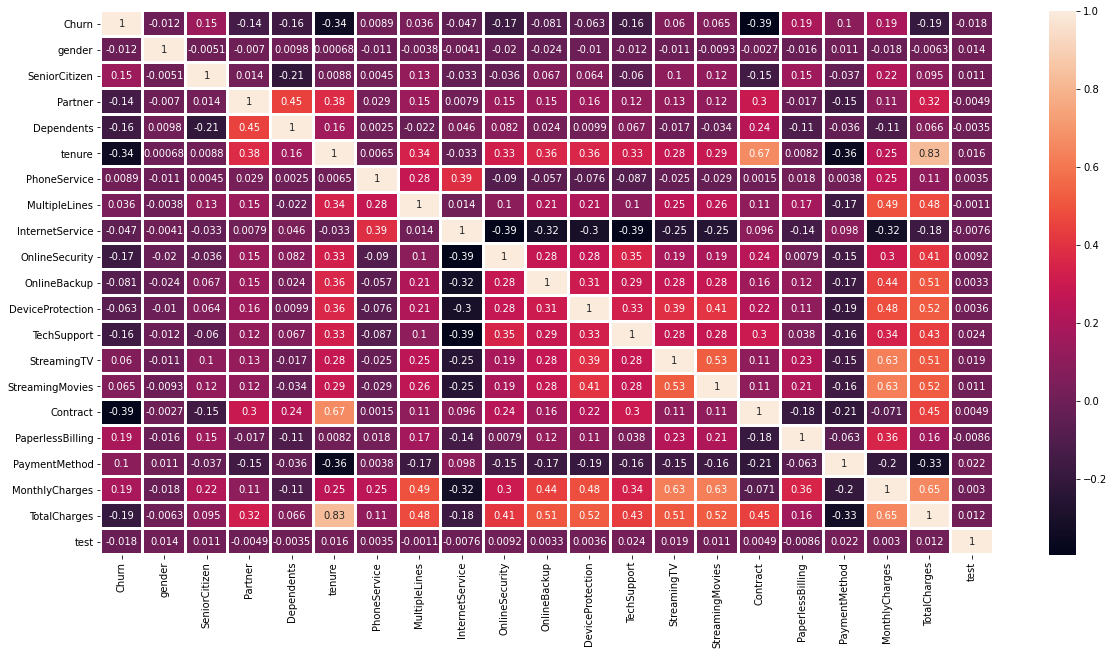

In [16]:
plt.figure(figsize=(20,10))
sns.heatmap(all_data.corr(), annot=True, linewidths=2)

In [22]:
toDrop = ["gender", "PhoneService", "MultipleLines", "tenure", "StreamingTV"]

all_data = all_data.drop(toDrop, axis=1)

In [25]:
all_data.head(10)

,Churn,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,test
0,1,1,1,0,1,0,0,0,0,0,0,1,2,70.15,916.75,0
1,0,1,1,1,1,0,0,1,1,1,1,1,0,103.90,6767.10,0
2,0,0,1,1,0,1,0,1,0,0,1,0,3,34.80,1980.30,0
3,1,0,0,0,0,1,1,1,0,1,0,1,0,68.85,1970.50,0
4,1,1,0,0,1,1,0,0,0,1,0,1,2,100.80,1308.10,0
5,0,0,0,0,2,0,0,0,0,0,0,1,3,20.25,20.25,0
6,0,0,1,1,0,1,0,1,1,1,2,0,3,75.70,4676.70,0
7,0,0,1,0,0,1,1,0,1,0,0,1,1,66.40,2727.80,0
8,0,0,1,1,0,1,0,0,1,1,0,0,0,81.00,1923.85,0
9,0,0,1,0,1,1,1,0,0,0,0,0,2,90.35,190.50,0


### Riseparazione dei dati


In [29]:
train_set = all_data[all_data.test == 0].drop("test", axis=1)
test_set = all_data[all_data.test == 1].drop("test", axis=1)

In [30]:
y_train = train_set.Churn
x_train = train_set.drop("Churn", axis=1)
y_test = test_set.Churn
x_test = test_set.drop("Churn", axis=1)

Acc: 0.7876995860437611


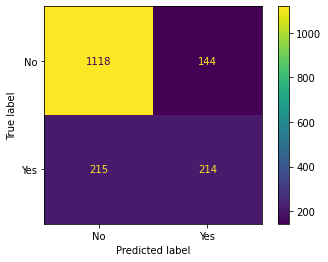

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1262
           1       0.60      0.50      0.54       429

    accuracy                           0.79      1691
   macro avg       0.72      0.69      0.70      1691
weighted avg       0.78      0.79      0.78      1691



In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

model = LogisticRegression(random_state = 0, max_iter = 1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(f"Acc: {accuracy_score(y_pred, y_test)}")
plot_confusion_matrix(model, x_test, y_test, values_format='n', display_labels=['No','Yes'])
plt.show()
print(classification_report(y_test,y_pred))
